In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.data import Dataset

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  ds = Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(batch_size + 1))
  ds = ds.shuffle(shuffle_buffer_size).map(lambda x: (x[:-1], x[-1:]))
  ds = ds.batch(batch_size).prefetch(1)

  return ds

In [ ]:
train_set = windowed_dataset(x_train, window_size,batch_size,shuffle_buffer_size)
model = Sequential([
                    Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                    SimpleRNN(40, return_sequences=True),
                    SimpleRNN(40),
                    Dense(1),
                    Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 40ms/step - loss: 96.5879 - mae: 97.0879 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 38ms/step - loss: 92.7452 - mae: 93.2452 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 37ms/step - loss: 87.9328 - mae: 88.4325 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 37ms/step - loss: 82.2774 - mae: 82.7767 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 37ms/step - loss: 75.5484 - mae: 76.0484 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 37ms/step - loss: 67.2775 - mae: 67.7769 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 37ms/step - loss: 56.9687 - mae: 57.4684 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 38ms/step - loss: 44.5910 - mae: 45.0910 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 39ms/step - loss: 32.1545 - mae:

(1e-08, 0.001, 0.0, 100.0)

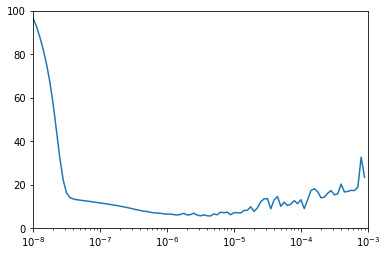

In [ ]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8, 1e-3, 0,100 ])

In [ ]:
class mycallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('loss') < 9):
      print('Loss is minimized!')
      self.model.stop_training = True

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=3e-6, momentum=0.9)
mycallback = mycallback()
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model.fit(train_set, epochs=500, callbacks=[mycallback])

Epoch 1/500
31/31 [==============================] - 1s 37ms/step - loss: 14.1464 - mae: 14.6371
Epoch 2/500
31/31 [==============================] - 1s 39ms/step - loss: 14.1191 - mae: 14.6105
Epoch 3/500
31/31 [==============================] - 1s 37ms/step - loss: 14.1203 - mae: 14.6108
Epoch 4/500
31/31 [==============================] - 1s 39ms/step - loss: 14.1077 - mae: 14.5970
Epoch 5/500
31/31 [==============================] - 1s 38ms/step - loss: 14.1005 - mae: 14.5910
Epoch 6/500
31/31 [==============================] - 1s 39ms/step - loss: 14.1148 - mae: 14.6030
Epoch 7/500
31/31 [==============================] - 1s 39ms/step - loss: 14.1010 - mae: 14.5898
Epoch 8/500
31/31 [==============================] - 1s 38ms/step - loss: 14.0879 - mae: 14.5778
Epoch 9/500
31/31 [==============================] - 1s 38ms/step - loss: 14.0868 - mae: 14.5757
Epoch 10/500
31/31 [==============================] - 1s 39ms/step - loss: 14.1068 - mae: 14.5953
Epoch 11/500
31/31 [=========

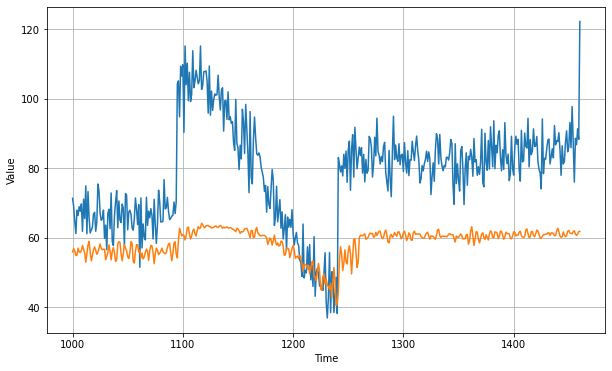

In [ ]:
forecast = []

for time in range(len(series)- window_size):
  tmp = series[time:time+window_size]
  tmp = np.expand_dims(tmp, axis=0)
  forecast.append(model.predict(tmp))

val_forecast = np.array(forecast[split_time-window_size:])

val_pred = val_forecast[:,0,0]
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, val_pred)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, val_pred).numpy()

20.263199

In [ ]:
model = Sequential([
                    Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                    Bidirectional(LSTM(32, return_sequences=True)),
                    Bidirectional(LSTM(32)),
                    Dense(1),
                    Lambda(lambda x: x * 100.0)
])

In [ ]:
#Reset th
tf.keras.backend.clear_session()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=3e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model.fit(train_set, epochs=500)

Epoch 1/500
31/31 [==============================] - 0s 12ms/step - loss: 6.9632 - mae: 7.4444
Epoch 2/500
31/31 [==============================] - 0s 13ms/step - loss: 6.4598 - mae: 6.9387
Epoch 3/500
31/31 [==============================] - 0s 12ms/step - loss: 6.2116 - mae: 6.6939
Epoch 4/500
31/31 [==============================] - 0s 13ms/step - loss: 6.0394 - mae: 6.5206
Epoch 5/500
31/31 [==============================] - 0s 12ms/step - loss: 5.7488 - mae: 6.2303
Epoch 6/500
31/31 [==============================] - 0s 13ms/step - loss: 5.5919 - mae: 6.0675
Epoch 7/500
31/31 [==============================] - 0s 12ms/step - loss: 5.4910 - mae: 5.9685
Epoch 8/500
31/31 [==============================] - 0s 13ms/step - loss: 5.3782 - mae: 5.8575
Epoch 9/500
31/31 [==============================] - 0s 12ms/step - loss: 5.2675 - mae: 5.7451
Epoch 10/500
31/31 [==============================] - 0s 13ms/step - loss: 5.2294 - mae: 5.7061
Epoch 11/500
31/31 [=============================

6.7995706


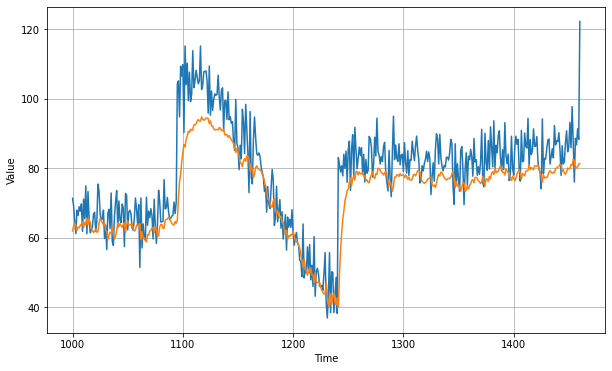

In [ ]:
forecast = []

for time in range(len(series)- window_size):
  tmp = series[time:time+window_size]
  tmp = np.expand_dims(tmp, axis=0)
  forecast.append(model.predict(tmp))

val_forecast = np.array(forecast[split_time-window_size:])

val_pred = val_forecast[:,0,0]
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, val_pred)

print(tf.keras.metrics.mean_absolute_error(x_valid, val_pred).numpy())